# Multi-GPU Training Example

Train a convolutional neural network on multiple GPU with TensorFlow.

## Import modules

In [35]:
import sys
print(sys.version)

3.6.2 (default, Oct  1 2017, 03:29:21) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]


In [32]:
import os
import time
#!pip install -q -U tensorflow-gpu
import tensorflow as tf
import numpy as np
import keras
from keras import backend as K
from keras.datasets import mnist # dataset
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import ipywidgets

import utils
from utils import reset_tf_session
from utils import download_file
from utils import ModelSaveCallback

1.12.0
2.2.4


In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [36]:
x_train[0].shape

(28, 28)

The dataset is saved in ~/.keras/datasets/mnist.npz

In [25]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [26]:
NUM_DIGITS = 10
mnist_digits = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

/Users/molinaro/tf_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


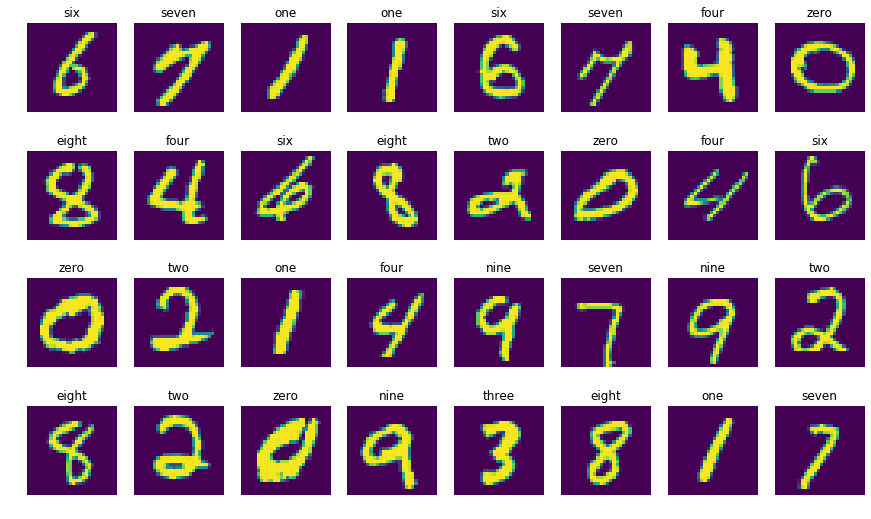

In [28]:
# show random images from train
cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('False')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(mnist_digits[y_train[random_index]])
plt.show()

## Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [29]:
# normalize inputs
x_train2 = x_train/255-0.5 
x_test2 = x_test/255-0.5 

y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=NUM_DIGITS) 
y_test2 = tf.keras.utils.to_categorical(y_test, num_classes=NUM_DIGITS) 

## Define CNN architecture

We need to add one channel to the train images in order to set them as viable inputs for the CNN.

We need to define a model which takes __(None, 28, 28, 1)__ input and predicts __(None, 10)__ output with probabilities for all digits. __None__ in shapes stands for batch dimension.

In [46]:
x_train2 = x_train2.reshape(len(x_train), 28,28,1)
x_test2 = x_test2.reshape(len(x_test),28,28,1)

In [47]:
def make_model():
    """
    Model architecture.
    """
    
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(5, 5),padding='same',input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(256,kernel_size=(5, 5),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256,kernel_size=(3, 3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(512,kernel_size=(3, 3),padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(2048))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(2048))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_DIGITS))  
    model.add(Activation("softmax"))
    
    
    return model

In [48]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       409856    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       590080    
__________

## Train model

In [49]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005
 5280/60000 [=>............................] - ETA: 1:29:32 - loss: 14.3646 - acc: 0.1040

KeyboardInterrupt: 

In [ ]:
# save weights to file
model.save_weights("mnist_weights.h5")

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("mnist_weights.h5")

In [ ]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = mnist_digits[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

## Create an estimator form the compiled Keras model

We convert the model created above to run on a multi-GPU environment using the TensorFlow Estimator API.
Estimators build the graph, so there is no explicit session here.

We build esimators using the tf.keras.estimator.model_to_estimator method.

We use the tf.contrib.distribute.MirroredStrategy paradigm to do in-graph replication of synchronous training: 
Each worker GPU has a copy of the network and gets a subset of the data on which it computes the local gradients and then waits for all the workers to finish in a synchronous manner. Then the workers communicate their local gradients to each other via a Ring All-reduce operation which is typically optimized to reduce network bandwidth and increase through-put. Once all the gradients have arrived each worker averages them and updates its parameter and the next step begins. This is ideal in situations where you have multiple GPUs on a single node connected via some high-speed interconnect.

In [ ]:
NUM_GPUS = 2
strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
config = tf.estimator.RunConfig(train_distribute=strategy)
estimator = tf.keras.estimator.model_to_estimator(model, config=config)

We need to define a data importing function to pipe data into our Estimator.

In [ ]:
# ETL process

def input_fn(images, labels, epochs, batch_size):
    # Convert the inputs to a Dataset. (E)
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    # Shuffle, repeat, and batch the examples. (T)
    SHUFFLE_SIZE = 5000
    ds = ds.shuffle(SHUFFLE_SIZE).repeat(epochs).batch(batch_size)
    ds = ds.prefetch(2)
    # Return the dataset. (L)
    return ds

### Train the Estimator

In [ ]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []
    def before_run(self, run_context):
        self.iter_time_start = time.time()
    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [ ]:
time_hist = TimeHistory()
BATCH_SIZE = 512
EPOCHS = 5
estimator.train(lambda:input_fn(train_images,
                                train_labels,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE),
                hooks=[time_hist])

### Performance

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with {NUM_GPUS} GPU(s): {total_time} seconds")
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE*NUM_GPUS/avg_time_per_batch} images/second with
        {NUM_GPUS} GPU(s)")


### Evaluate the Estimator

In [ ]:
estimator.evaluate(lambda:input_fn(test_images, 
                                   test_labels,
                                   epochs=1,
                                   batch_size=BATCH_SIZE))